# Implicit Hybrid Model for Movie Recommendation
> Testing out the features of Collie Recs library on MovieLens-100K. Training Factorization and Hybrid models with Pytorch Lightning.

- toc: true
- badges: true
- comments: true
- categories: [Implicit, PyTorch, PyTorchLightening, Collie, Movie, Factorization, HybridModel, Visualization]
- author: "<a href='https://github.com/ShopRunner/collie_recs'>ShopRunner</a>"
- image:

## Setup

In [1]:
!pip install -q collie_recs
!pip install -q git+https://github.com/sparsh-ai/recochef.git

In [82]:
import os
import joblib
import numpy as np
import pandas as pd

from collie_recs.interactions import Interactions
from collie_recs.interactions import ApproximateNegativeSamplingInteractionsDataLoader
from collie_recs.cross_validation import stratified_split
from collie_recs.metrics import auc, evaluate_in_batches, mapk, mrr
from collie_recs.model import CollieTrainer, MatrixFactorizationModel, HybridPretrainedModel
from collie_recs.movielens import get_recommendation_visualizations

import torch
from pytorch_lightning.utilities.seed import seed_everything

from recochef.datasets.movielens import MovieLens
from recochef.preprocessing.encode import label_encode as le

from IPython.display import HTML

In [3]:
# this handy PyTorch Lightning function fixes random seeds across all the libraries used here
seed_everything(22)

Global seed set to 22


22

## Data Loading

In [4]:
data_object = MovieLens()

In [61]:
df = data_object.load_interactions()
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## Preprocessing

In [62]:
# drop duplicate user-item pair records, keeping recent ratings only
df.drop_duplicates(subset=['USERID','ITEMID'], keep='last', inplace=True)

In [63]:
# convert the explicit data to implicit by only keeping interactions with a rating ``>= 4``
df = df[df.RATING>=4].reset_index(drop=True)
df['RATING'] = 1

In [64]:
# label encode
df, umap = le(df, col='USERID')
df, imap = le(df, col='ITEMID')

df = df.astype('int64')

In [39]:
df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,1,884182806
1,1,1,1,891628467
2,2,2,1,879781125
3,3,3,1,876042340
4,4,4,1,879270459


In [40]:
user_counts = df.groupby(by='USERID')['ITEMID'].count()
user_list = user_counts[user_counts>=3].index.tolist()
df = df[df.USERID.isin(user_list)]

df.head()

,USERID,ITEMID,RATING,TIMESTAMP
0,0,0,1,884182806
1,1,1,1,891628467
2,2,2,1,879781125
3,3,3,1,876042340
4,4,4,1,879270459


### Interactions
While we have chosen to represent the data as a ``pandas.DataFrame`` for easy viewing now, Collie uses a custom ``torch.utils.data.Dataset`` called ``Interactions``. This class stores a sparse representation of the data and offers some handy benefits, including: 

* The ability to index the data with a ``__getitem__`` method 
* The ability to sample many negative items (we will get to this later!) 
* Nice quality checks to ensure data is free of errors before model training 

Instantiating the object is simple! 

In [41]:
interactions = Interactions(
    users=df['USERID'],
    items=df['ITEMID'],
    ratings=df['RATING'],
    allow_missing_ids=True,
)

interactions

Checking for and removing duplicate user, item ID pairs...
Checking ``num_negative_samples`` is valid...
Maximum number of items a user has interacted with: 378
Generating positive items set...


Interactions object with 48616 interactions between 941 users and 1447 items, returning 10 negative samples per interaction.

### Data Splits 
With an ``Interactions`` dataset, Collie supports two types of data splits. 

1. **Random split**: This code randomly assigns an interaction to a ``train``, ``validation``, or ``test`` dataset. While this is significantly faster to perform than a stratified split, it does not guarantee any balance, meaning a scenario where a user will have no interactions in the ``train`` dataset and all in the ``test`` dataset is possible. 
2. **Stratified split**: While this code runs slower than a random split, this guarantees that each user will be represented in the ``train``, ``validation``, and ``test`` dataset. This is by far the most fair way to train and evaluate a recommendation model. 

Since this is a small dataset and we have time, we will go ahead and use ``stratified_split``. If you're short on time, a ``random_split`` can easily be swapped in, since both functions share the same API! 

In [42]:
train_interactions, val_interactions = stratified_split(interactions, test_p=0.1, seed=42)
train_interactions, val_interactions

Generating positive items set...
Generating positive items set...


(Interactions object with 43508 interactions between 941 users and 1447 items, returning 10 negative samples per interaction.,
 Interactions object with 5108 interactions between 941 users and 1447 items, returning 10 negative samples per interaction.)

## Train a Matrix Factorization Model

### Model Architecture 
With our data ready-to-go, we can now start training a recommendation model. While Collie has several model architectures built-in, the simplest by far is the ``MatrixFactorizationModel``, which use ``torch.nn.Embedding`` layers and a dot-product operation to perform matrix factorization via collaborative filtering. 

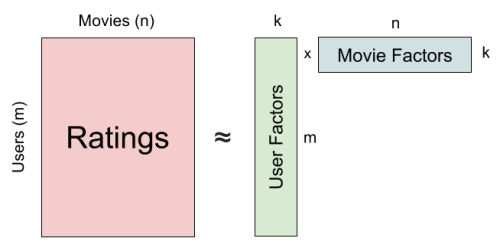

Digging through the code of [``collie_recs.model.MatrixFactorizationModel``](../collie_recs/model.py) shows the architecture is as simple as we might think. For simplicity, we will include relevant portions below so we know exactly what we are building: 

````python
def _setup_model(self, **kwargs) -> None:
    self.user_biases = ZeroEmbedding(num_embeddings=self.hparams.num_users,
                                     embedding_dim=1,
                                     sparse=self.hparams.sparse)
    self.item_biases = ZeroEmbedding(num_embeddings=self.hparams.num_items,
                                     embedding_dim=1,
                                     sparse=self.hparams.sparse)
    self.user_embeddings = ScaledEmbedding(num_embeddings=self.hparams.num_users,
                                           embedding_dim=self.hparams.embedding_dim,
                                           sparse=self.hparams.sparse)
    self.item_embeddings = ScaledEmbedding(num_embeddings=self.hparams.num_items,
                                           embedding_dim=self.hparams.embedding_dim,
                                           sparse=self.hparams.sparse)

        
def forward(self, users: torch.tensor, items: torch.tensor) -> torch.tensor:
    user_embeddings = self.user_embeddings(users)
    item_embeddings = self.item_embeddings(items)

    preds = (
        torch.mul(user_embeddings, item_embeddings).sum(axis=1)
        + self.user_biases(users).squeeze(1)
        + self.item_biases(items).squeeze(1)
    )

    if self.hparams.y_range is not None:
        preds = (
            torch.sigmoid(preds)
            * (self.hparams.y_range[1] - self.hparams.y_range[0])
            + self.hparams.y_range[0]
        )

    return preds
````

Let's go ahead and instantiate the model and start training! Note that even if you are running this model on a CPU instead of a GPU, this will still be relatively quick to fully train. 

Collie is built with PyTorch Lightning, so all the model classes and the ``CollieTrainer`` class accept all the training options available in PyTorch Lightning. Here, we're going to set the embedding dimension and learning rate differently, and go with the defaults for everything else

In [43]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
)

In [44]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.


Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.


Epoch     9: reducing learning rate of group 0 to 1.0000e-06.
Epoch     9: reducing learning rate of group 0 to 1.0000e-06.


### Evaluate the Model 
We have a model! Now, we need to figure out how well we did. Evaluating implicit recommendation models is a bit tricky, but Collie offers the following metrics that are built into the library. They use vectorized operations that can run on the GPU in a single pass for speed-ups. 

* [``Mean Average Precision at K (MAP@K)``](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) 
* [``Mean Reciprocal Rank``](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) 
* [``Area Under the Curve (AUC)``](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) 

We'll go ahead and evaluate all of these at once below. 

In [45]:
model.eval()  # set model to inference mode
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.030123216170802932
MRR Score:    0.18514649777472775
AUC Score:    0.866987761170696


### Inference

We can also look at particular users to get a sense of what the recs look like. 

In [46]:
# select a random user ID to look at recommendations for
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=model,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,Bad Boys (1995),When Harry Met Sally... (1989),Sleeper (1973),Richard III (1995),Cold Comfort Farm (1995),"Lawnmower Man, The (1992)",Batman Forever (1995),"Graduate, The (1967)",Independence Day (ID4) (1996),Star Wars (1977)
Recommended films:,,,,,,,,,,


### Save and Load a Standard Model 

In [47]:
# we can save the model with...
os.makedirs('models', exist_ok=True)
model.save_model('models/matrix_factorization_model.pth')

In [48]:
# ... and if we wanted to load that model back in, we can do that easily...
model_loaded_in = MatrixFactorizationModel(load_model_path='models/matrix_factorization_model.pth')

model_loaded_in

MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(941, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(941, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

Now that we've built our first model and gotten some baseline metrics, we now will be looking at some more advanced features in Collie's ``MatrixFactorizationModel``. 

## Faster Data Loading Through Approximate Negative Sampling 

With sufficiently large enough data, verifying that each negative sample is one a user has *not* interacted with becomes expensive. With many items, this can soon become a bottleneck in the training process. 

Yet, when we have many items, the chances a user has interacted with most is increasingly rare. Say we have ``1,000,000`` items and we want to sample ``10`` negative items for a user that has positively interacted with ``200`` items. The chance that we accidentally select a positive item in a random sample of ``10`` items is just ``0.2%``. At that point, it might be worth it to forgo the expensive check to assert our negative sample is true, and instead just randomly sample negative items with the hope that most of the time, they will happen to be negative. 

This is the theory behind the ``ApproximateNegativeSamplingInteractionsDataLoader``, an alternate DataLoader built into Collie. Let's train a model with this below, noting how similar this procedure looks to that in the previous tutorial. 

In [50]:
train_loader = ApproximateNegativeSamplingInteractionsDataLoader(train_interactions, batch_size=1024, shuffle=True)
val_loader = ApproximateNegativeSamplingInteractionsDataLoader(val_interactions, batch_size=1024, shuffle=False)

In [51]:
model = MatrixFactorizationModel(
    train=train_loader,
    val=val_loader,
    embedding_dim=10,
    lr=1e-2,
)

In [52]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)
model.eval()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(941, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(941, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [53]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.027979833367276323
MRR Score:    0.1703751336709069
AUC Score:    0.8517987786322347


We're seeing a small hit on performance and only a marginal improvement in training time compared to the standard ``MatrixFactorizationModel`` model because MovieLens 100K has so few items. ``ApproximateNegativeSamplingInteractionsDataLoader`` is especially recommended for when we have more items in our data and training times need to be optimized. 

For more details on this and other DataLoaders in Collie (including those for out-of-memory datasets), check out the [docs](https://collie.readthedocs.io/en/latest/index.html)! 

## Multiple Optimizers 

Training recommendation models at ShopRunner, we have encountered something we call "the curse of popularity." 

This is best thought of in the viewpoint of a model optimizer - say we have a user, a positive item, and several negative items that we hope have recommendation scores that score lower than the positive item. As an optimizer, you can either optimize every single embedding dimension (hundreds of parameters) to achieve this, or instead choose to score a quick win by optimizing the bias terms for the items (just add a positive constant to the positive item and a negative constant to each negative item). 

While we clearly want to have varied embedding layers that reflect each user and item's taste profiles, some models learn to settle for popularity as a recommendation score proxy by over-optimizing the bias terms, essentially just returning the same set of recommendations for every user. Worst of all, since popular items are... well, popular, **the loss of this model will actually be decent, solidifying the model getting stuck in a local loss minima**. 

To counteract this, Collie supports multiple optimizers in a ``MatrixFactorizationModel``. With this, we can have a faster optimizer work to optimize the embedding layers for users and items, and a slower optimizer work to optimize the bias terms. With this, we impel the model to do the work actually coming up with varied, personalized recommendations for users while still taking into account the necessity of the bias (popularity) terms on recommendations. 

At ShopRunner, we have seen significantly better metrics and results from this type of model. With Collie, this is simple to do, as shown below. 

In [54]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
    bias_lr=1e-1,
    optimizer='adam',
    bias_optimizer='sgd',
)

In [55]:
trainer = CollieTrainer(model, max_epochs=10, deterministic=True)

trainer.fit(model)
model.eval()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-02.


MatrixFactorizationModel(
  (user_biases): ZeroEmbedding(941, 1)
  (item_biases): ZeroEmbedding(1447, 1)
  (user_embeddings): ScaledEmbedding(941, 10)
  (item_embeddings): ScaledEmbedding(1447, 10)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [56]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.03243186201880122
MRR Score:    0.19819369246580287
AUC Score:    0.8617710409716284


Again, we're not seeing as much performance increase here compared to the standard model because MovieLens 100K has so few items. For a more dramatic difference, try training this model on a larger dataset, such as MovieLens 10M, adjusting the architecture-specific hyperparameters, or train longer. 

## Item-Item Similarity 

While we've trained every model thus far to work for member-item recommendations (given a *member*, recommend *items* - think of this best as "Personalized recommendations for you"), we also have access to item-item recommendations for free (given a seed *item*, recommend similar *items* - think of this more like "People who interacted with this item also interacted with..."). 

With Collie, accessing this is simple! 

In [68]:
df_item = data_object.load_items()
df_item.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [69]:
df_item = le(df_item, col='ITEMID', maps=imap)
df_item.head()

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
0,9.0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,160.0,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,579.0,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,25.0,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,436.0,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [70]:
df_item.loc[df_item['TITLE'] == 'GoldenEye (1995)']

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
1,160.0,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [71]:
# let's start by finding movies similar to GoldenEye (1995)
item_similarities = model.item_item_similarity(item_id=160)

item_similarities

160    1.000000
123    0.842003
948    0.828162
398    0.827030
197    0.826931
         ...   
26    -0.654127
88    -0.680429
165   -0.697536
499   -0.729313
312   -0.780792
Length: 1447, dtype: float64

In [72]:
df_item.iloc[item_similarities.index][:5]

,ITEMID,TITLE,RELEASE,VIDRELEASE,URL,UNKNOWN,ACTION,ADVENTURE,ANIMATION,CHILDREN,COMEDY,CRIME,DOCUMENTARY,DRAMA,FANTASY,FILMNOIR,HORROR,MUSICAL,MYSTERY,ROMANCE,SCIFI,THRILLER,WAR,WESTERN
162,182.0,"Return of the Pink Panther, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
125,229.0,"Spitfire Grill, The (1996)",06-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Spitfire%20Gr...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
975,933.0,Solo (1996),23-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Solo%20(1996),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
401,175.0,Ghost (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Ghost%20(1990),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
199,72.0,"Shining, The (1980)",01-Jan-1980,NaN,"http://us.imdb.com/M/title-exact?Shining,%20Th...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Unfortunately, not seen these movies. Can't say if these are relevant.

``item_item_similarity`` method is available in all Collie models, not just ``MatrixFactorizationModel``! 

Next, we will incorporate item metadata into recommendations for even better results.

## Partial Credit Loss
Most of the time, we don't *only* have user-item interactions, but also side-data about our items that we are recommending. These next two notebooks will focus on incorporating this into the model training process. 

In this notebook, we're going to add a new component to our loss function - "partial credit". Specifically, we're going to use the genre information to give our model "partial credit" for predicting that a user would like a movie that they haven't interacted with, but is in the same genre as one that they liked. The goal is to help our model learn faster from these similarities. 

### Read in Data

To do the partial credit calculation, we need this data in a slightly different form. Instead of the one-hot-encoded version above, we're going to make a ``1 x n_items`` tensor with a number representing the first genre associated with the film, for simplicity. Note that with Collie, we could instead make a metadata tensor for each genre

In [76]:
df_item.columns[5:]

Index(['UNKNOWN', 'ACTION', 'ADVENTURE', 'ANIMATION', 'CHILDREN', 'COMEDY',
       'CRIME', 'DOCUMENTARY', 'DRAMA', 'FANTASY', 'FILMNOIR', 'HORROR',
       'MUSICAL', 'MYSTERY', 'ROMANCE', 'SCIFI', 'THRILLER', 'WAR', 'WESTERN'],
      dtype='object')

In [89]:
metadata_df = df_item[df_item.columns[5:]]

In [77]:
genres = (
    torch.tensor(metadata_df.values)
    .topk(1)
    .indices
    .view(-1)
)

genres

tensor([ 5,  1, 16,  ..., 14,  5,  8])

### Train a model with our new loss

now, we will pass in ``metadata_for_loss`` and ``metadata_for_loss_weights`` into the model ``metadata_for_loss`` should have a tensor containing the integer representations for metadata we created above for every item ID in our dataset ``metadata_for_loss_weights`` should have the weights for each of the keys in ``metadata_for_loss``

In [78]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=10,
    lr=1e-2,
    metadata_for_loss={'genre': genres},
    metadata_for_loss_weights={'genre': 0.4},
)

In [79]:
trainer = CollieTrainer(model=model, max_epochs=10, deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 9.4 K 
3 | item_embeddings | ScaledEmbedding | 14.5 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


### Evaluate the Model 

Again, we'll evaluate the model and look at some particular users' recommendations to get a sense of what these recommendations look like using a partial credit loss function during model training. 

In [80]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'MAP@10 Score: {mapk_score}')
print(f'MRR Score:    {mrr_score}')
print(f'AUC Score:    {auc_score}')


MAP@10 Score: 0.02882727154889818
MRR Score:    0.1829242957435939
AUC Score:    0.8585049499223719


Broken record alert: we're not seeing as much performance increase here compared to the standard model because MovieLens 100K has so few items. For a more dramatic difference, try training this model on a larger dataset, such as MovieLens 10M, adjusting the architecture-specific hyperparameters, or train longer. 

### Inference

In [81]:
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=model,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,Cold Comfort Farm (1995),"Apartment, The (1960)",Blown Away (1994),Star Wars (1977),Star Trek: First Contact (1996),"Sex, Lies, and Videotape (1989)","Big Squeeze, The (1996)","Client, The (1994)",Jerry Maguire (1996),"Ghost and the Darkness, The (1996)"
Recommended films:,,,,,,,,,,


Partial credit loss is useful when we want an easy way to boost performance of any implicit model architecture, hybrid or not. When tuned properly, partial credit loss more fairly penalizes the model for more egregious mistakes and relaxes the loss applied when items are more similar. 

Of course, the loss function isn't the only place we can incorporate this metadata - we can also directly use this in the model (and even use a hybrid model combined with partial credit loss). Next, we will train a hybrid Collie model! 

## Hybrid Factorization Model

### Train a ``MatrixFactorizationModel`` 

The first step towards training a Collie Hybrid model is to train a regular ``MatrixFactorizationModel`` to generate rich user and item embeddings. We'll use these embeddings in a ``HybridPretrainedModel`` a bit later. 

In [83]:
model = MatrixFactorizationModel(
    train=train_interactions,
    val=val_interactions,
    embedding_dim=30,
    lr=1e-2,
)

In [84]:
trainer = CollieTrainer(model=model, max_epochs=10, deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_biases     | ZeroEmbedding   | 941   
1 | item_biases     | ZeroEmbedding   | 1.4 K 
2 | user_embeddings | ScaledEmbedding | 28.2 K
3 | item_embeddings | ScaledEmbedding | 43.4 K
4 | dropout         | Dropout         | 0     
----------------------------------------------------
74.0 K    Trainable params
0         Non-trainable params
74.0 K    Total params
0.296     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


In [85]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, model)

print(f'Standard MAP@10 Score: {mapk_score}')
print(f'Standard MRR Score:    {mrr_score}')
print(f'Standard AUC Score:    {auc_score}')


Standard MAP@10 Score: 0.024415062120220127
Standard MRR Score:    0.1551878337645617
Standard AUC Score:    0.8575152364604943


### Train a ``HybridPretrainedModel`` 

With our trained ``model`` above, we can now use these embeddings and additional side data directly in a hybrid model. The architecture essentially takes our user embedding, item embedding, and item metadata for each user-item interaction, concatenates them, and sends it through a simple feedforward network to output a recommendation score. 

We can initially freeze the user and item embeddings from our previously-trained ``model``, train for a few epochs only optimizing our newly-added linear layers, and then train a model with everything unfrozen at a lower learning rate. We will show this process below. 

In [87]:
HybridPretrainedModel??

In [90]:
# we will apply a linear layer to the metadata with ``metadata_layers_dims`` and
# a linear layer to the combined embeddings and metadata data with ``combined_layers_dims``
hybrid_model = HybridPretrainedModel(
    train=train_interactions,
    val=val_interactions,
    item_metadata=metadata_df,
    trained_model=model,
    metadata_layers_dims=[8],
    combined_layers_dims=[16],
    lr=1e-2,
    freeze_embeddings=True,
)

In [91]:
hybrid_trainer = CollieTrainer(model=hybrid_model, max_epochs=10, deterministic=True)

hybrid_trainer.fit(hybrid_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | _trained_model   | MatrixFactorizationModel | 74.0 K
1 | embeddings       | Sequential               | 71.6 K
2 | dropout          | Dropout                  | 0     
3 | metadata_layer_0 | Linear                   | 160   
4 | combined_layer_0 | Linear                   | 1.1 K 
5 | combined_layer_1 | Linear                   | 17    
--------------------------------------------------------------
75.3 K    Trainable params
71.6 K    Non-trainable params
146 K     Total params
0.588     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch    10: reducing learning rate of group 0 to 1.0000e-03.



In [92]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc], val_interactions, hybrid_model)

print(f'Hybrid MAP@10 Score: {mapk_score}')
print(f'Hybrid MRR Score:    {mrr_score}')
print(f'Hybrid AUC Score:    {auc_score}')


Hybrid MAP@10 Score: 0.02650305521043056
Hybrid MRR Score:    0.15837650977843062
Hybrid AUC Score:    0.780685132170672


In [93]:
hybrid_model_unfrozen = HybridPretrainedModel(
    train=train_interactions,
    val=val_interactions,
    item_metadata=metadata_df,
    trained_model=model,
    metadata_layers_dims=[8],
    combined_layers_dims=[16],
    lr=1e-4,
    freeze_embeddings=False,
)

hybrid_model.unfreeze_embeddings()
hybrid_model_unfrozen.load_from_hybrid_model(hybrid_model)

In [94]:
hybrid_trainer_unfrozen = CollieTrainer(model=hybrid_model_unfrozen, max_epochs=10, deterministic=True)

hybrid_trainer_unfrozen.fit(hybrid_model_unfrozen)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                     | Params
--------------------------------------------------------------
0 | _trained_model   | MatrixFactorizationModel | 74.0 K
1 | embeddings       | Sequential               | 71.6 K
2 | dropout          | Dropout                  | 0     
3 | metadata_layer_0 | Linear                   | 160   
4 | combined_layer_0 | Linear                   | 1.1 K 
5 | combined_layer_1 | Linear                   | 17    
--------------------------------------------------------------
75.3 K    Trainable params
71.6 K    Non-trainable params
146 K     Total params
0.588     Total estimated model params size (MB)


Detected GPU. Setting ``gpus`` to 1.


Global seed set to 22


Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


### Evaluate the Model

In [95]:
mapk_score, mrr_score, auc_score = evaluate_in_batches([mapk, mrr, auc],
                                                       val_interactions,
                                                       hybrid_model_unfrozen)

print(f'Hybrid Unfrozen MAP@10 Score: {mapk_score}')
print(f'Hybrid Unfrozen MRR Score:    {mrr_score}')
print(f'Hybrid Unfrozen AUC Score:    {auc_score}')


Hybrid Unfrozen MAP@10 Score: 0.02789580198163252
Hybrid Unfrozen MRR Score:    0.17139103232628614
Hybrid Unfrozen AUC Score:    0.8118089364191508


### Inference

In [96]:
user_id = np.random.randint(10, train_interactions.num_users)

display(
    HTML(
        get_recommendation_visualizations(
            model=hybrid_model_unfrozen,
            user_id=user_id,
            filter_films=True,
            shuffle=True,
            detailed=True,
        )
    )
)

,Willy Wonka and the Chocolate Factory (1971),Mighty Aphrodite (1995),Conspiracy Theory (1997),Sense and Sensibility (1995),Liar Liar (1997),In & Out (1997),Return of the Jedi (1983),Ransom (1996),Emma (1996),Toy Story (1995)
Some loved films:,,,,,,,,,,
,Jerry Maguire (1996),Bad Boys (1995),Blown Away (1994),"Santa Clause, The (1994)",Tin Cup (1996),"Graduate, The (1967)",Cold Comfort Farm (1995),"Princess Bride, The (1987)",Private Benjamin (1980),True Romance (1993)
Recommended films:,,,,,,,,,,


The metrics and results look great, and we should only see a larger difference compared to a standard model as our data becomes more nuanced and complex (such as with MovieLens 10M data). 

If we're happy with this model, we can go ahead and save it for later! 

### Save and Load a Hybrid Model 

In [97]:
# we can save the model with...
os.makedirs('models', exist_ok=True)
hybrid_model_unfrozen.save_model('models/hybrid_model_unfrozen')

In [98]:
# ... and if we wanted to load that model back in, we can do that easily...
hybrid_model_loaded_in = HybridPretrainedModel(load_model_path='models/hybrid_model_unfrozen')


hybrid_model_loaded_in

HybridPretrainedModel(
  (embeddings): Sequential(
    (0): ScaledEmbedding(941, 30)
    (1): ScaledEmbedding(1447, 30)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (metadata_layer_0): Linear(in_features=19, out_features=8, bias=True)
  (combined_layer_0): Linear(in_features=68, out_features=16, bias=True)
  (combined_layer_1): Linear(in_features=16, out_features=1, bias=True)
)

Thus far, we keep our focus only on the implicit feedback based matrix factorization model on small movielens dataset. In future, we will be expanding this MVP in the following directions:
1. Large scale industrial datasets - Yoochoose, Trivago
2. Other available models in [this](https://github.com/ShopRunner/collie_recs/tree/main/collie_recs/model) repo
3. Really liked the poster carousel. Put it in dash/streamlit app.